In [905]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip

import xflib
# Coordinate transformation library
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
import matplotlib.gridspec as gridspec

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.basemap import Basemap


from matplotlib import collections  as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors


import matplotlib as mpl


# %matplotlib inline
%matplotlib notebook
# %matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load input energies (precalculated), convert to densities
inlats = [50, 35, 15]
mlts   = [0, 12]
rootdir ='/shared/users/asousa/WIPP/WIPP_stencils/'
power_dir    = os.path.join(rootdir,'outputs','input_energies_0.25deg')

R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.

I0 = 10000.
all_data = []
for inlat in inlats:
    for mlt in [0, 12]:
        fn = os.path.join(power_dir,'input_energy_%d_%d.pklz'%(inlat, mlt))
        print os.path.exists(fn)
        with gzip.open(fn,'rb') as file:
            data = pickle.load(file)
        
        
        # Get areas of each cell (for energy density)
        
        areas = np.zeros([len(data['clats']), len(data['clons'])])
        
        
        dlat = data['clats'][1] - data['clats'][0]
        dlon = data['clons'][1] - data['clons'][0] 
        
        # Get areas of each cell, in km:
        cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos(data['clats']*D2R))
        
        # Sum over frequencies:
        data['pwr'] = np.sum(data['pwr'], axis=0)
        data['pwr']*= pow(I0,2)  # scale by peak current
        data['pwr']/= cell_areas[:, np.newaxis] # Divide by area to get density
        data['pwr'] = np.hstack([np.fliplr(data['pwr'][:,:-1]), data['pwr']]) # Flip for both sides of flash
        
        x = data['clons']
        data['clons'] = np.hstack([x[:-1] - x[-1] + x[0], x])
        print np.shape(data['clons'])
        print np.shape(data['clats'])
        print np.shape(data['pwr'])
        all_data.append(data)



True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)
True
(159,)
(40,)
(40, 159)


In [3]:


i = 2
in_lats = all_data[i]['clats']
in_lons = all_data[i]['clons']

newlats = np.linspace(in_lats[0], in_lats[-1], 200)
newlons = np.linspace(in_lons[0], in_lons[-1], 200)
interp = interpolate.RegularGridInterpolator([in_lats, in_lons], np.log10(all_data[i]['pwr']))
px, py = np.meshgrid(newlons, newlats)
pts = zip(py.ravel(), px.ravel())
flux = (interp(pts)).reshape(len(newlons), len(newlats))


# flux = all_data[i]['pwr']
lons, lats = np.meshgrid(newlons, newlats)
flashtime = datetime.datetime(2010,1,4,0,0,0)
tmp_coords = coord.Coords(zip(np.ones_like(lats.ravel()), lats.ravel(), lons.ravel()),'MAG','sph',units=['Re','deg','deg'])
tvec_datetime = [flashtime for s in lats.ravel()]
tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
tmp_coords = tmp_coords.convert('GEO','sph')


geo_lons = tmp_coords.long.reshape(np.shape(lats))
geo_lats = tmp_coords.lati.reshape(np.shape(lats))



<IPython.core.display.Javascript object>


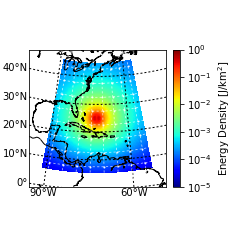

In [233]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 2.25 
fig_height = 2.25
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


# gs = gridspec.GridSpec(1,2, width_ratios=[1,0.05])

clims = [-5,0]
fig, ax = plt.subplots(1,1)

h = 10000
m = Basemap(projection='lcc', lon_0 = -72, lat_0 = 25, width=50*111*1e3, height = 50*111*1e3, resolution='l')


m.drawcoastlines()
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,10.), labels=[True, False, False, False ])
m.drawmeridians(np.arange(0.,420.,30.), labels = [False, True, False, True])

# Plot the data
x, y = m(geo_lons, geo_lats)
CS1 = m.pcolormesh(x,y,flux,cmap=plt.cm.jet, vmin=clims[0], vmax=clims[1])


# Plot the grid
grid_lons_mag = np.arange(-22.5, 23,5)
grid_lats_mag = np.arange(12.5,58,5)
# print in_lats
glons, glats = np.meshgrid(grid_lons_mag, grid_lats_mag)
tmp_coords = coord.Coords(zip(np.ones_like(glats.ravel()), glats.ravel(), glons.ravel()),'MAG','sph',units=['Re','deg','deg'])
tvec_datetime = [flashtime for s in glats.ravel()]
tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
tmp_coords = tmp_coords.convert('GEO','sph')

grid_lons_geo = tmp_coords.long.reshape(np.shape(glats))
grid_lats_geo = tmp_coords.lati.reshape(np.shape(glats))

px, py = m(grid_lons_geo, grid_lats_geo)

for ind, b in enumerate(glats):
    m.plot(px[ind,:], py[ind,:], ':',marker='o', markersize=1,color='w',linewidth=0.7, alpha=0.8)

for ind, b in enumerate(glons):
    m.plot(px[:,ind], py[:,ind], ':', color='w',linewidth=0.7,alpha=0.8)

cb = m.colorbar(CS1, location='right', pad="5%")

cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Energy Density [J/km$^2$]')

# fig.tight_layout()
fig.subplots_adjust(right=0.77)
fig.savefig('input_energy_with_grid.png', dpi=300)



<IPython.core.display.Javascript object>


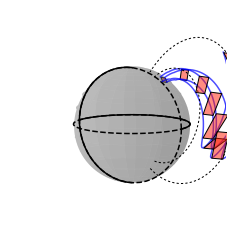

In [217]:
def interp_ray(rc, taxis):
    '''in-place interpolation of position (xyz) and sim time axes'''
    ix = interpolate.interp1d(rc.sim_time, rc.x)
    iy = interpolate.interp1d(rc.sim_time, rc.y)
    iz = interpolate.interp1d(rc.sim_time, rc.z)

    rc.x = ix(taxis)
    rc.y = iy(taxis)
    rc.z = iz(taxis)
    rc.sim_time = taxis

    
def plot_earth(ax):
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x = 1 * np.outer(np.cos(u), np.sin(v))
    y = 1 * np.outer(np.sin(u), np.sin(v))
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
    elev = 0.0
    rot = 0 / 180 * np.pi
    ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='grey', linewidth=0, alpha=0.3)
    a = np.array([-np.sin(elev / 180 * np.pi), 0, np.cos(elev / 180 * np.pi)])
    b = np.array([0, 1, 0])
    b = b * np.cos(rot) + np.cross(a, b) * np.sin(rot) + a * np.dot(a, b) * (1 - np.cos(rot))
    ax.plot(np.sin(u),np.cos(u),0,color='k', linestyle = 'dashed')
    horiz_front = np.linspace(0, np.pi, 100)
    ax.plot(np.sin(horiz_front),np.cos(horiz_front),0,color='k')
    vert_front = np.linspace(np.pi / 2, 3 * np.pi / 2, 100)
    ax.plot(a[0] * np.sin(u) + b[0] * np.cos(u), b[1] * np.cos(u), a[2] * np.sin(u) + b[2] * np.cos(u),color='k', linestyle = 'dashed')
    ax.plot(a[0] * np.sin(vert_front) + b[0] * np.cos(vert_front), b[1] * np.cos(vert_front), a[2] * np.sin(vert_front) + b[2] * np.cos(vert_front),color='k')


fig_width = 2.5 
fig_height = 2.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


# Load rayfile:
ray_root = '/shared/users/asousa/WIPP/Thesis figures/data/geometric_spreading_example/'
rayF = 200
lat_min = 0
lat_max = 90
lon_min = 0
lon_max = 360

flashtime = datetime.datetime(2010, 8, 1, 0, 0, 0)
R_E = 6371e3 # Radius of earth in meters
H_IONO = 1000e3
D2R = (np.pi/180.0)

rf = read_rayfiles(ray_root,rayF,lat_min, lat_max, lon_min, lon_max)

t_new = np.arange(0,5, step=0.05)

# plane_inds = np.arange(0, len(t_new), step=15)
plane_inds = [0, 10, 20, 30, 40, 50, 63, 80, -1]

psize = 1.8
pshift=0.5


# Convert to geographic coordinates for plotting:
rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + datetime.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    interp_ray(tmp_coords, t_new)
    rays.append(tmp_coords)


# -------- 3D Plot -------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")
ax._axis3don = False

# # Plot the earth
plot_earth(ax)


# Plot rays:
for r in rays:
    ax.plot(r.x/R_E, r.y/R_E, r.z/R_E, linewidth=1.5, color='blue', alpha=0.7)


Ls = [2, 3]
for L in Ls:
    # Plot the fieldlines
    
    latmax = np.arccos(np.sqrt(1.0/L))*R2D
    lam = np.linspace(-latmax,latmax,128)
    L_r = L*pow(np.cos(lam*D2R),2)
    phi = np.zeros_like(lam) + 3
    Ll = np.array([xf.sm2mag(xf.rllmag2sm([x[0], x[1], x[2]], flashtime), flashtime) for x in zip(L_r, lam, phi)])
    
    Lx = Ll[:,0]
    Ly = Ll[:,1]
    Lz = Ll[:,2]
    ax.plot(Lx,Ly,Lz,color='k',linewidth=1,linestyle='dotted')  # Field line
    

    
# # Plot polygons:
for ind in plane_inds:
    vtx = np.array([ [b.x[ind], b.y[ind], b.z[ind]] for b in [rays[0], rays[1], rays[3], rays[2]]])/R_E
    tri = a3.art3d.Poly3DCollection([vtx], color=[1,0.1,0,0.5])  # For reasons unknown, rgb + alpha= doesn't work.
    tri.set_edgecolor('k')
    ax.add_collection3d(tri)

    
    
ax.set_xlim([pshift, psize+pshift])
ax.set_ylim([0, psize])
ax.set_zlim([-psize/2., psize/2.])

ax.view_init(elev=5., azim=-50)


# fig.subplots_adjust(left=-0.8,right=2.)
fig.savefig('interpolation_globe1.pdf',margins='None')

ax.set_xlim([-psize/2., psize/2.])
ax.set_ylim([-psize/2., psize/2.])
ax.set_zlim([-psize/2., psize/2.])

ax.view_init(elev=0, azim=2.5)




<IPython.core.display.Javascript object>


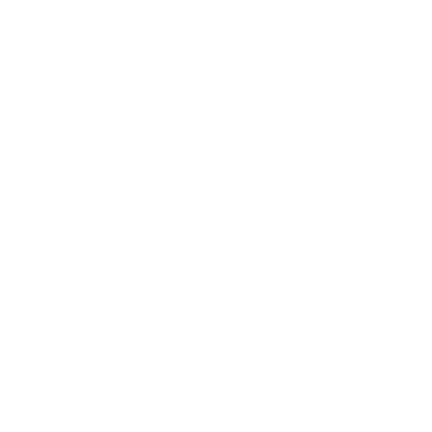

In [36]:

# --------------- Latex Plot Beautification --------------------------
fig_width = 5
fig_height = 5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
fig = plt.figure()
ax = Axes3D(fig)
# fig, ax = plt.subplots(1,1)

m = Basemap(projection='ortho',lon_0=-105,lat_0=40,resolution='l')
ax.add_collection3d(m.drawcoastlines())
# m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
# m.drawparallels(np.arange(-90.,120.,30.))
# m.drawmeridians(np.arange(0.,420.,60.))
# m.drawmapboundary(fill_color='aqua')
# map.bluemarble()
# ax.add_collection3d(map.drawcoastlines(linewidth=0.25))
# ax.add_collection3d(map.drawcountries(linewidth=0.35))



<IPython.core.display.Javascript object>


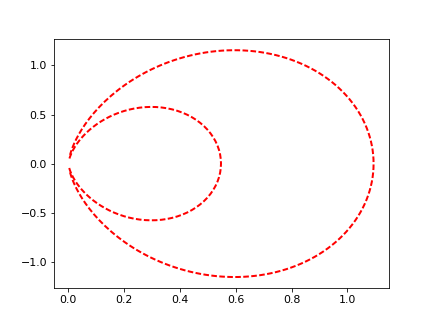

In [103]:
fig, ax = plt.subplots(1,1)

Ls = [1.5, 3]
for L in Ls:
    # Plot the fieldlines
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    phi = np.zeros_like(lam)
    
    Ll = np.array([xf.rllmag2sm([x[0], x[1], x[2]], datetime.datetime(2010,1,1,12,0,0)) for x in zip(L_r, lam, phi)])
    
    Lx = Ll[:,0]
    Ly = Ll[:,1]
    Lz = Ll[:,2]
    
    
    
# #     Lx  = L_r*np.cos(lam*D2R)
# #     Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Lz,color='r',linewidth=2,linestyle='dashed')  # Field line
    

## Delaunay volume illustration

<IPython.core.display.Javascript object>


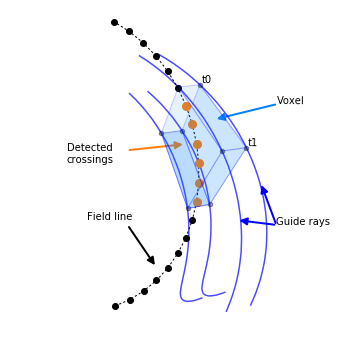

In [608]:
from scipy.spatial import Delaunay

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# --------------- Latex Plot Beautification --------------------------
fig_width = 4
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'text.fontsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
fig = plt.figure()
ax = Axes3D(fig)
ax._axis3don = False
# Plot volume cube:
i0 = 21
i1 = 31
Z = [[b.x[ind]/R_E, b.y[ind]/R_E, b.z[ind]/R_E] for b in [rays[0], rays[1], rays[2], rays[3]] for ind in [i0, i1]]
pts = [[Z[0],Z[1],Z[3],Z[2]],
      [Z[4],Z[5],Z[7],Z[6]],
      [Z[0],Z[1],Z[5],Z[4]],
      [Z[2],Z[3],Z[7],Z[6]],
      [Z[2],Z[3],Z[7],Z[6]],
      [Z[1],Z[3],Z[7],Z[5]]]

ax.add_collection3d(a3.art3d.Poly3DCollection(pts, 
 facecolors=[0,0.5,1,0.1], linewidths=1, edgecolors=[0,0,1,0.2]))


# Plot rays:
r1 = 15
r2 = 55
for r in rays:
    ax.plot(r.x[r1:r2]/R_E, r.y[r1:r2]/R_E, r.z[r1:r2]/R_E, linewidth=1.5, color='blue', alpha=0.7)

for row in Z:
    ax.scatter3D(row[0], row[1], row[2],facecolor='k',marker='o', alpha=0.4)

# Plot the fieldlines
L =2.2
latmax = np.arccos(np.sqrt(1.8/L))*R2D
lam = np.linspace(-latmax,latmax,20)
L_r = L*pow(np.cos(lam*D2R),2)
phi = np.zeros_like(lam) + 3
Ll = np.array([xf.sm2mag(xf.rllmag2sm([x[0], x[1], x[2]], flashtime), flashtime) for x in zip(L_r, lam, phi)])

Lx = Ll[:,0]
Ly = Ll[:,1]
Lz = Ll[:,2]
ax.plot(Lx,Ly,Lz,color='k',linewidth=1,linestyle='dotted')  # Field line



# Mark off points within volume! Just like we do for the real deal.
tri = Delaunay(Z, qhull_options='QJ')
hits = (tri.find_simplex(Ll) >= 0)
miss = ~hits
ax.plot3D(Ll[hits,0],Ll[hits,1],Ll[hits,2], marker='o', linewidth=0, color=plt.cm.Vega10(1), markersize=8)  # inside
ax.plot3D(Ll[miss,0],Ll[miss,1],Ll[miss,2], marker='o', linewidth=0, color='k', markersize=6)  # outside


c = Arrow3D([2.8, 2.4],
            [0, 0],
            [0.4, 0.3],
            mutation_scale=15, lw=2, arrowstyle="-|>", color=[0,0.5,1])
ax.add_artist(c)

ax.text(2.8,0,0.4,'Voxel', zdir=(1,0,.05))
ax.text(Z[1][0] +0.01, Z[1][1], Z[1][2]+0.01, 't1', zdir=(1,0,0.05))
ax.text(Z[0][0] +0.01, Z[0][1], Z[0][2]+0.01, 't0', zdir=(1,0,0.05))


c = Arrow3D([1.8, 2.0],
            [0, 0],
            [-0.3, -0.5],
            mutation_scale=15, lw=2, arrowstyle="-|>", color='k')
ax.add_artist(c)
ax.text(1.5,0,-0.3,'Field line')

c = Arrow3D([2.8, 2.7],
            [0, 0],
            [-0.2,-0],
            mutation_scale=15, lw=2, arrowstyle="-|>", color='b')
ax.add_artist(c)
c = Arrow3D([2.8, 2.55],
            [0, 0],
            [-0.2,-0.2],
            mutation_scale=15, lw=2, arrowstyle="-|>", color='b')
ax.add_artist(c)
ax.text(2.8,0,-0.2,'Guide rays')

c = Arrow3D([1.8, 2.2],
            [0, 0],
            [0.1,0.16],
            mutation_scale=15, lw=2, arrowstyle="-|>", color=plt.cm.Vega10(1))
ax.add_artist(c)
ax.text(1.35,0,0,'Detected\ncrossings')




ax.set_xlim([1.7,2.7])
ax.set_ylim([-0.5,0.5])
ax.set_zlim([-0.5,0.5])
ax.set_aspect('equal')
ax.view_init(azim=-49, elev=7)

fig.savefig('delaunay_1.pdf')

## Convex hull figure

<IPython.core.display.Javascript object>


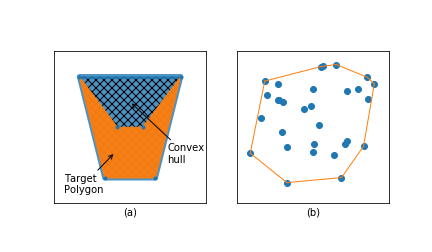

[[-1.01072818  0.17947721]
 [-0.60320082 -0.09274695]
 [ 1.21420757  0.85483638]
 [ 1.00174942 -0.37520483]
 [-1.23115675 -0.51147266]
 [-0.02743528  0.41230944]
 [-0.59402068  0.50049331]
 [-0.49925495 -0.39775735]
 [-0.50904894 -1.09107445]
 [ 0.01471345 -0.49576975]
 [-0.90620798  0.63369264]
 [ 1.09672959  0.56479581]
 [-0.69392709  0.54406742]
 [ 0.414465   -0.55589767]
 [ 0.15729042  1.19519991]
 [ 1.07948505  0.98333239]
 [-0.17050602  0.36192958]
 [ 0.6766981  -0.27746939]
 [ 0.89743639  0.75842997]
 [ 0.20289606  1.19915129]
 [ 0.11871783  0.04728529]
 [ 0.56741949 -0.99187377]
 [-0.68964221  0.84632629]
 [ 0.46358502  1.23715757]
 [ 0.0178621  -0.32331057]
 [ 0.62748971 -0.33114724]
 [ 0.00215165  0.75219434]
 [-0.66491268  0.5308537 ]
 [-0.94594217  0.91017994]
 [ 0.68112115  0.71834564]]
[8 4]
[28  4]
[21  8]
[3 2]
[ 3 21]
[15  2]
[15 23]
[14 28]
[14 23]


In [688]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import ConvexHull
fig, ax = plt.subplots(1,2)

N = 5

# --------------- Latex Plot Beautification --------------------------
fig_width = 5
fig_height = 2.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'text.fontsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


pts_cvx = [[-1,1],[-0.5,-1],[0.5,-1],[1,1]]
pts_full = np.array([[-1,1],[-0.5,-1],[0.5,-1],[1,1],[0.25,0],[-0.25,0]])

patches = []
poly0 = Polygon(pts_cvx, True, label='Convex Hull')
patches.append(poly0)
p = PatchCollection(patches, alpha=0.8, hatch='xxx',color=plt.cm.Vega10(0), linewidth=5)
ax[0].add_collection(p)

patches = []
poly1 = Polygon(pts_full, True)
patches.append(poly1)
p = PatchCollection(patches, alpha=0.95, color=plt.cm.Vega10(1), hatch='', label='Target')
ax[0].add_collection(p)

ax[0].scatter(pts_full[:,0],pts_full[:,1], marker='.')
ax[0].legend()


ax[0].set_xlim([-1.5,1.5])
ax[0].set_ylim([-1.5,1.5])


pts_rand = np.random.rand(30,2)*2.5 - 1.25
print pts_rand

hull = ConvexHull(pts_rand)
for simplex in hull.simplices:
    print simplex
    ax[1].plot(pts_rand[simplex,0], pts_rand[simplex,1],color=plt.cm.Vega10(1), linewidth=1)

ax[1].scatter(pts_rand[:,0],pts_rand[:,1])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# ax[0].text(-1.2, -1.3, "Target")
ax[0].annotate("Target\nPolygon", xy=(-0.3, -0.5), xytext=(-1.3, -1.3),
    arrowprops=dict(arrowstyle="->"))
ax[0].annotate("Convex\nhull", xy=(0, 0.5), xytext=(0.73, -0.7),
    arrowprops=dict(arrowstyle="->"))

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].set_xlabel('(a)')
ax[1].set_xlabel('(b)')

ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])

fig.savefig('convex_hulls.pdf') 


## Frequency Interpolation Figure

In [ ]:
from scipy.spatial import Delaunay

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# --------------- Latex Plot Beautification --------------------------
fig_width = 4
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'text.fontsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------



rf = read_rayfiles(ray_root, 200, 0, 90,-360, 360)
t_new = np.arange(0,5, step=0.05)

# Convert to geographic coordinates for plotting:
rays_lo = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + datetime.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    interp_ray(tmp_coords, t_new)
    rays_lo.append(tmp_coords)
    
rf = read_rayfiles(ray_root, 500, 0, 90,-360, 360)

# Convert to geographic coordinates for plotting:
rays_hi = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + datetime.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    interp_ray(tmp_coords, t_new)
    rays_hi.append(tmp_coords)

<IPython.core.display.Javascript object>


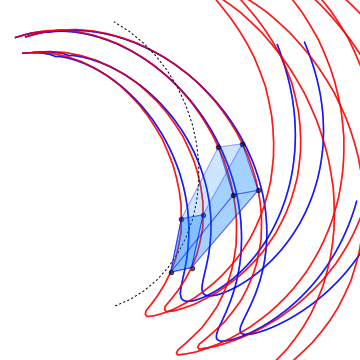

In [697]:
fig = plt.figure()
ax = Axes3D(fig)
ax._axis3don = False

# for rayset in [rays_lo, rays_hi]:

for ind in [0, 1]:
    
    
    # Interpolate ray set:
    
    
    # Plot volume cube:
    i0 = 18
    i1 = 22
    Z = [[b.x[ind]/R_E, b.y[ind]/R_E, b.z[ind]/R_E] for b in [rayset[0], rayset[1], rayset[2], rayset[3]] for ind in [i0, i1]]
    pts = [[Z[0],Z[1],Z[3],Z[2]],
          [Z[4],Z[5],Z[7],Z[6]],
          [Z[0],Z[1],Z[5],Z[4]],
          [Z[2],Z[3],Z[7],Z[6]],
          [Z[2],Z[3],Z[7],Z[6]],
          [Z[1],Z[3],Z[7],Z[5]]]

    ax.add_collection3d(a3.art3d.Poly3DCollection(pts, 
     facecolors=[0,0.5,1,0.1], linewidths=1, edgecolors=[0,0,1,0.2]))

    # Plot rays:
    r1 = 0
    r2 = -1
    for r in rays_lo:
        ax.plot(r.x[r1:r2]/R_E, r.y[r1:r2]/R_E, r.z[r1:r2]/R_E, linewidth=1.5, color=, alpha=0.7)

    for r in rays_hi:
        ax.plot(r.x[r1:r2]/R_E, r.y[r1:r2]/R_E, r.z[r1:r2]/R_E, linewidth=1.5, color='red', alpha=0.7)


    for row in Z:
        ax.scatter3D(row[0], row[1], row[2],facecolor='k',marker='o', alpha=0.4)

# Plot the fieldlines
L =2.2
latmax = np.arccos(np.sqrt(1.8/L))*R2D
lam = np.linspace(-latmax,latmax,20)
L_r = L*pow(np.cos(lam*D2R),2)
phi = np.zeros_like(lam) + 3
Ll = np.array([xf.sm2mag(xf.rllmag2sm([x[0], x[1], x[2]], flashtime), flashtime) for x in zip(L_r, lam, phi)])

Lx = Ll[:,0]
Ly = Ll[:,1]
Lz = Ll[:,2]
ax.plot(Lx,Ly,Lz,color='k',linewidth=1,linestyle='dotted')  # Field line


ax.set_xlim([1.7,2.7])
ax.set_ylim([-0.5,0.5])
ax.set_zlim([-0.5,0.5])
ax.set_aspect('equal')
ax.view_init(azim=-49, elev=7)

# fig.savefig('delaunay_1.pdf')

Loading freq: 100
Loading freq: 300


<IPython.core.display.Javascript object>


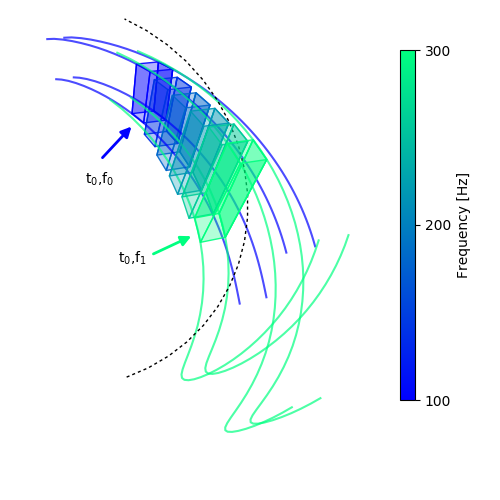

In [942]:
#  This version is clipped more-or-less from ray_interp_Lshell.
#  It's in SM coordinates instead of cartesian Mag.

#--------------- Load and interpolate the center longitude entries ------------------------------------

t = np.arange(0,3, 0.05)

def rotate_latlon(raypos, itime, dlat, dlon, xf=None):
    if xf is None:
        xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
        
    newpos = np.zeros_like(raypos)
    for ind in range(np.shape(raypos)[1]):
#         print ind
        tmp = xf.sm2rllmag(raypos[:,ind], itime)
        tmp[1] += dlat
        tmp[2] += dlon
        newpos[:,ind] = xf.rllmag2sm(tmp, itime)
    
    return newpos

def flatten_longitude_variation(raypos, itime, xf=None):
    if xf is None:
        xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
        
    newpos = np.zeros_like(raypos)

    tmp = xf.sm2rllmag(raypos[:,0], itime)
    start_lon = tmp[2]

    for ind in range(np.shape(raypos)[1]):
#         print ind
        tmp = xf.sm2rllmag(raypos[:,ind], itime)
        # tmp[1] += dlat
        tmp[2] = start_lon
        newpos[:,ind] = xf.rllmag2sm(tmp, itime)
    
    return newpos

def voxel_vol_nd(points):
    '''
    volume of a polygon in n-dimensional space. Rad.
    '''
    n, m = np.shape(points)
    tri = Delaunay(points.T, qhull_options='QJ')
    v = 0
    for row in tri.simplices:
        mat = points[:, row[1:]].T - points[:, row[0]].T
        v += np.abs(np.linalg.det(mat)/math.factorial(n))
    return v



f1 = 100; f2 = 300
lat1 = 30; lat2 = 35
lon1 = 0; lon2 = 5

ray_root = '/shared/users/asousa/WIPP/rays/geo_spreading/'
ray_data = dict()
for freq in [f1, f2]:
    print "Loading freq: %d"%freq
    for lat in [lat1, lat2]:
        for lon in [lon1, lon2]:
            filename = os.path.join(ray_root,'f_%d'%freq,'lon_%d'%lon,'ray_%d_%d_%d.ray'%(freq,lat,lon))
    #         print filename
            rf = read_rayfile(filename)[0]

#             filename = os.path.join(ray_root,'f_%d'%freq,'lon_%d'%lon,'damp_%d_%d_%d.ray'%(freq,lat,lon))
#             df = read_damp(filename)[0]

            t_cur = t[t <= rf['time'].iloc[-1]]

            # Interpolate onto our new time axis:
            x = interpolate.interp1d(rf['time'],rf['pos']['x']).__call__(t_cur)/R_E
            y = interpolate.interp1d(rf['time'],rf['pos']['y']).__call__(t_cur)/R_E
            z = interpolate.interp1d(rf['time'],rf['pos']['z']).__call__(t_cur)/R_E
#             d = interpolate.interp1d(df['time'],df['damping'], bounds_error=False, fill_value=0).__call__(t_cur)

            # Stash it somewhere:
            key = (freq, lat, lon)
            curdata = dict()

            # Flatten out any longitude variation, just to be sure:
            curdata['pos'] = np.vstack([x,y,z])
            # curdata['pos'] = np.vstack([x,y,z])
#             curdata['damp']= d
            curdata['nt'] = len(t_cur)
            ray_data[key] = curdata



fig = plt.figure()
ax = Axes3D(fig)
ax._axis3don = False

# Interpolate ray set:
k0 = (f1, lat1, lon1)
k1 = (f1, lat2, lon1)
k2 = (f2, lat1, lon1)
k3 = (f2, lat2, lon1)
k4 = (f1, lat1, lon2)
k5 = (f1, lat2, lon2)
k6 = (f2, lat1, lon2)
k7 = (f2, lat2, lon2)

# Plot volume cube:
i0 = 21
i1 = 23

# plot_earth(ax)


cmap = plt.cm.winter
for a in np.linspace(0,1.,6, dtype='float'): # interpolation weight (between 0 and 1)
    Z = []
    W = np.array([1.-a, a])
    for ka, kb in [(k0,k2),(k1,k3),(k5,k7),(k4,k6)]:
        P = [b['pos'][:,i0] for b in [ray_data[ka],ray_data[kb]]]
        Z.append(W.dot(P))
    for ka, kb in [(k0, k2),(k1,k3),(k5,k7),(k4,k6)]:
        P = [b['pos'][:,i1] for b in [ray_data[ka],ray_data[kb]]]
        Z.append(W.dot(P))

    pts = [[Z[0],Z[1],Z[2],Z[3]],
      [Z[4],Z[5],Z[6],Z[7]],
      [Z[0],Z[1],Z[5],Z[4]],
      [Z[2],Z[3],Z[7],Z[6]],
      [Z[2],Z[3],Z[7],Z[6]]]
#       [Z[1],Z[3],Z[5],Z[7]]]
    shadey_color = cmap(a)
    shadey_color = [shadey_color[0],shadey_color[1],shadey_color[2],0.3]
    edgey_color  = [shadey_color[0],shadey_color[1],shadey_color[2],0.9]


    derp = ax.add_collection3d(a3.art3d.Poly3DCollection(pts, 
     facecolors=shadey_color, linewidths=1, edgecolors=edgey_color))

# Plot rays:
r1 = 10
r2 = 60
for r in [ray_data[k0],ray_data[k1],ray_data[k4],ray_data[k5]]:
    ax.plot(r['pos'][0,r1:r2], r['pos'][1,r1:r2], r['pos'][2,r1:r2], linewidth=1.5, color=cmap(0.), alpha=0.7)

for r in [ray_data[k2],ray_data[k3],ray_data[k6],ray_data[k7]]:
    ax.plot(r['pos'][0,r1:r2], r['pos'][1,r1:r2], r['pos'][2,r1:r2], linewidth=1.5, color=cmap(1.), alpha=0.7)


# for row in Z:
#     ax.scatter3D(row[0], row[1], row[2],facecolor='k',marker='o', alpha=0.4)

# Plot the fieldlines
L =2.2
latmax = np.arccos(np.sqrt(1.8/L))*R2D
lam = np.linspace(-latmax,latmax,20)
L_r = L*pow(np.cos(lam*D2R),2)
phi = np.zeros_like(lam) + 3
Ll = np.array([xf.rllmag2sm([x[0], x[1], x[2]], flashtime) for x in zip(L_r, lam, phi)])

Lx = Ll[:,0]
Ly = Ll[:,1]
Lz = Ll[:,2]
ax.plot(Lx,Ly,Lz,color='k',linewidth=1,linestyle='dotted')  # Field line


ax.set_xlim([-0.5,0.5])
ax.set_ylim([2.5,3.5])
ax.set_zlim([-0.5,0.5])
ax.set_aspect('equal')
ax.view_init(azim=47, elev=7)
ax.set_xlabel('x')
ax.set_ylabel('y')

cax = fig.add_axes([0.8, 0.2, 0.03, 0.7])

norm = mpl.colors.Normalize(vmin=f1, vmax=f2)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_ticks([f1, 0.5*(f1 + f2), f2])
cb1.set_label('Frequency [Hz]')


c = Arrow3D([0, 0],
            [2.1, 2.3],
            [0.25, 0.4],
            mutation_scale=15, lw=2, arrowstyle="-|>", color=cmap(0))
ax.add_artist(c)
ax.text(0,2.0,0.15,'t$_0$,f$_0$')

c = Arrow3D([0, 0],
            [2.4, 2.65],
            [-0.1, 0.0],
            mutation_scale=15, lw=2, arrowstyle="-|>", color=cmap(1.))
ax.add_artist(c)
ax.text(0,2.2,-0.15,'t$_0$,f$_1$')


fig.savefig('delaunay_2.pdf')

In [891]:
fig.add_axes?

In [771]:
for a in [0,1]: # interpolation weight (between 0 and 1)
    Z = []
    W = np.array([1-a, a])
#         # Interpolate ray set:
#     k0 = (f1, lat1, lon1)
#     k1 = (f1, lat2, lon1)
#     k2 = (f2, lat1, lon1)
#     k3 = (f2, lat2, lon1)
#     k4 = (f1, lat1, lon2)
#     k5 = (f1, lat2, lon2)
#     k6 = (f2, lat1, lon2)
#     k7 = (f2, lat2, lon2)

    for ka, kb in [(k0, k2),(k1,k3),(k5,k7),(k4,k6)]:
        P = [b['pos'][:,i0] for b in [ray_data[ka],ray_data[kb]]]
        Z.append(W.dot(P))
    for ka, kb in [(k0, k2),(k1,k3),(k5,k7),(k4,k6)]:
        P = [b['pos'][:,i1] for b in [ray_data[ka],ray_data[kb]]]
        Z.append(W.dot(P))


        
    pts = [[Z[0],Z[1],Z[3],Z[2]],
      [Z[4],Z[5],Z[7],Z[6]],
      [Z[0],Z[1],Z[5],Z[4]],
      [Z[2],Z[3],Z[7],Z[6]],
      [Z[2],Z[3],Z[7],Z[6]],
      [Z[1],Z[3],Z[7],Z[5]]]


In [840]:
cmap?